In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')

import copy
import math
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import wandb
from torch.optim.lr_scheduler import SequentialLR, LinearLR, ExponentialLR, CosineAnnealingLR
from torch.utils.data import DataLoader, Subset, random_split

from data_utils import *
from model import *
from waveforms.waveforms_module.make_waveform import BatchedLightSimulation

seed = 42
torch.manual_seed(42)

In [2]:
path = '/sdf/home/c/carsmith/sdf_data/flash_detection_data/flash_files/delay_200ks/2_8_NEW.npy'
train_loader, val_loader, test_loader = make_wf_dataloaders(path, seed=seed)

/sdf/home/c/carsmith/flash_reconstruction/self_supervised_flash/data_utils.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  hit_times = torch.tensor(hit_times)


hit_times: torch.Size([25, 8])
Batch shape:  torch.Size([25, 1, 8000])
Arrival times shape:  torch.Size([25, 1, 8000])
Photon bins shape:  torch.Size([25, 1, 8000])
Total photons in wf:  2736


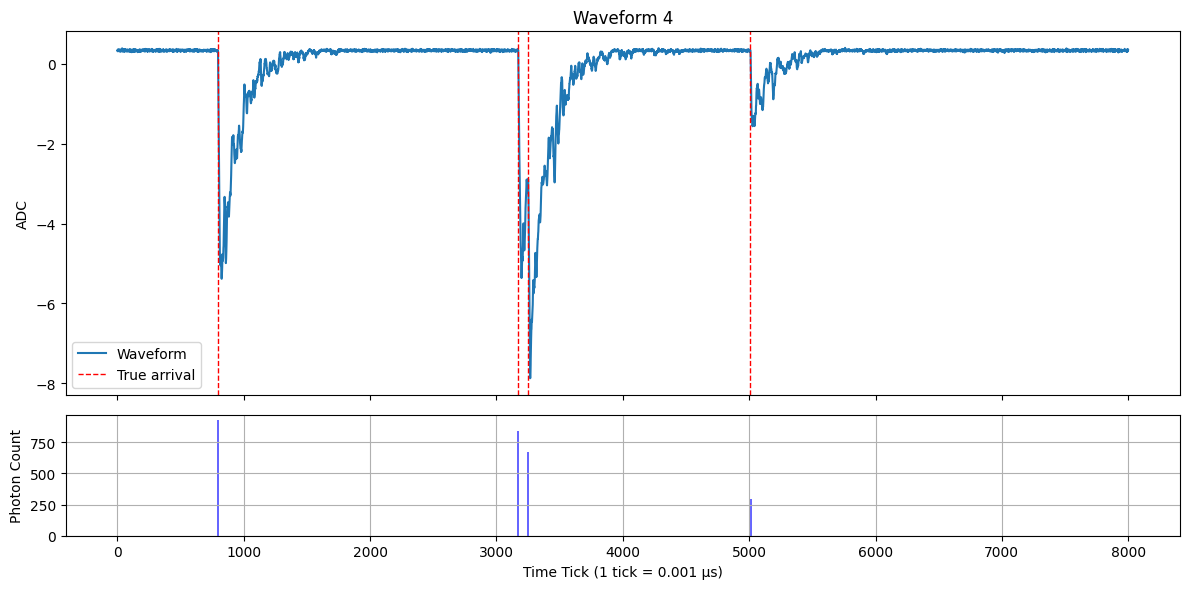

In [3]:
waveforms, arrival_times, hit_times, photon_bins, photon_list = next(iter(train_loader))
print(f"hit_times: {hit_times.shape}")
print('Batch shape: ', waveforms.shape)
print('Arrival times shape: ', arrival_times.shape)
print('Photon bins shape: ', photon_bins.shape)

waveform_id = 4
wf = waveforms[waveform_id]  # [1, L]
ticks = torch.arange(wf.shape[-1])  # [0, 1, ..., L-1]
wf = wf.squeeze(0)  # [L]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 6), sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# --- Top panel: waveform ---
ax1.plot(ticks, wf, alpha=1, label='Waveform')

# Mark true hits
for j, t in enumerate(hit_times[waveform_id]):
    if t >= 0:
        ax1.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )

ax1.set_title(f"Waveform {waveform_id}")
ax1.set_ylabel("ADC")
ax1.legend()

# --- Bottom panel: photon counts ---
photon_counts = photon_bins[waveform_id].cpu().numpy()
print("Total photons in wf: ", photon_counts[0].sum())
ax2.bar(ticks, photon_counts[0], width=20.0, color='b', alpha=0.6)
ax2.set_ylabel("Photon Count")
ax2.set_xlabel("Time Tick (1 tick = 0.001 μs)")
ax2.grid()
plt.tight_layout()
plt.show()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student = ConformerModel()
teacher = copy.deepcopy(student) # identical starting weights
student, teacher = student.to(device), teacher.to(device)
total_params = sum(p.numel() for p in student.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 11,226,626


torch.Size([25, 1, 8000])
torch.Size([25, 256, 800])


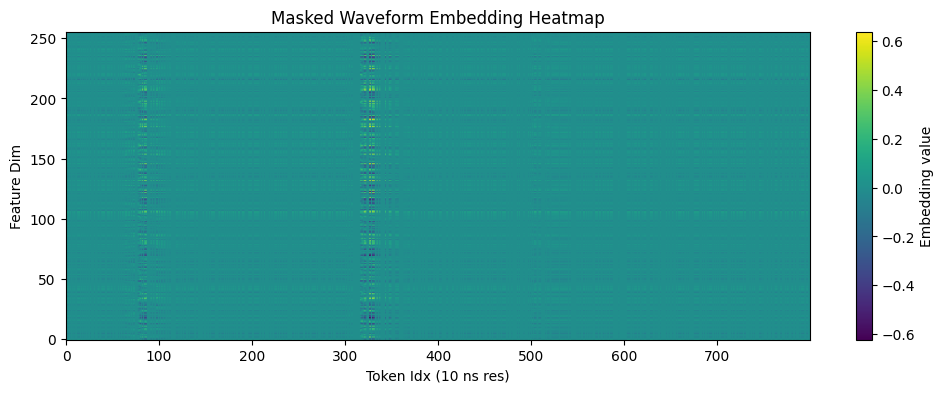

In [5]:
# Inspect 
import matplotlib.cm as cm

print(waveforms.shape)

tokenizer = MultiLevelTokenizer(
                in_channels=1,
                hidden_dim=256,
                kernel_sizes=[20, 50, 100, 400],
                window_len=8000,
                token_size=10,
                downsample='conv_mlp_lite'
            )

pos_encoder = PositionalEncoding(d_model=256, max_len=8000)

x = tokenizer(waveforms)
waveformMask = RandomMasking(masking_p=0.5)
_, masked_wfs = waveformMask(x) #[25, 256, 800]

print(masked_wfs.shape)
x = masked_wfs[waveform_id]

x_np = x.detach().cpu().numpy()  # convert to numpy if it's a tensor

# viridis = cm.get_cmap("viridis")
# colored = viridis((x_np - x_np.min()) / (x_np.max() - x_np.min()))
# colored[x_np == 0] = [1, 0, 0, 1]

plt.figure(figsize=(12, 4))
plt.imshow(x_np, aspect='auto', origin='lower', cmap='viridis')
# plt.imshow(colored, aspect='auto', origin='lower')
plt.colorbar(label='Embedding value')
plt.xlabel('Token Idx (10 ns res)')
plt.ylabel('Feature Dim')
plt.title('Masked Waveform Embedding Heatmap')
plt.show()

(256, 8000)


Text(0, 0.5, 'Feature Dim')

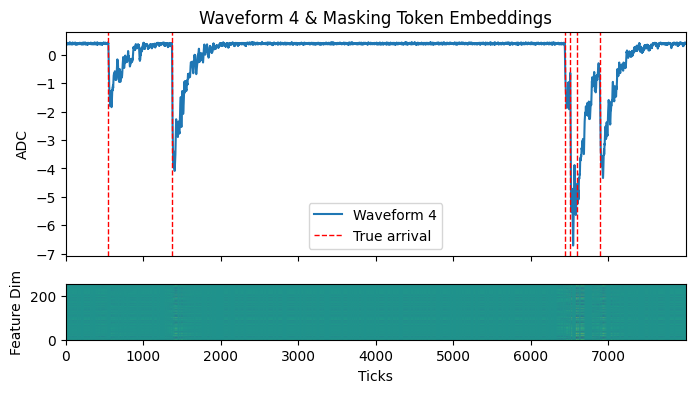

In [74]:
waveform_id = 4
wf = waveforms[waveform_id]  # [1, L]
ticks = torch.arange(wf.shape[-1])  # [0, 1, ..., L-1]
wf = wf.squeeze(0)  # [L]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(8, 4), sharex=True,
    gridspec_kw={'height_ratios': [4, 1]}
)

# --- Top panel: waveform ---
ax1.plot(ticks, wf, alpha=1, label=f'Waveform {waveform_id}')

# Mark true hits
for j, t in enumerate(hit_times[waveform_id]):
    if t >= 0:
        ax1.axvline(
            x=t.item(), 
            color='r', 
            linestyle='--', 
            linewidth=1, 
            label='True arrival' if j == 0 else ""
        )

ax1.set_title(f"Waveform {waveform_id} & Masking Token Embeddings")
ax1.set_ylabel("ADC")
ax1.legend()
x_np_repeated = np.repeat(x_np, repeats=10, axis=1)
print(x_np_repeated.shape)
ax2.imshow(x_np_repeated, aspect='auto', origin='lower', cmap='viridis')
ax2.set_xlabel("Ticks")
ax2.set_ylabel("Feature Dim")

### Ponder the results

In [6]:
# Load the checkpoint
device = 'cuda'
model = ConformerModel()
model.to(device)
checkpoint = torch.load(f"/sdf/home/c/carsmith/sdf_data/self_supervised_flash/dino_mask50_token10_5epochs.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

ConformerModel(
  (tokenizer): MultiLevelTokenizer(
    (convs): ModuleList(
      (0): Conv1d(1, 256, kernel_size=(20,), stride=(1,), padding=(10,))
      (1): Conv1d(1, 256, kernel_size=(50,), stride=(1,), padding=(25,))
      (2): Conv1d(1, 256, kernel_size=(100,), stride=(1,), padding=(50,))
      (3): Conv1d(1, 256, kernel_size=(400,), stride=(1,), padding=(200,))
    )
    (downsample): Sequential(
      (0): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): GELU(approximate='none')
      (2): Conv1d(256, 256, kernel_size=(10,), stride=(10,), groups=256, bias=False)
      (3): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
    (proj): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
  )
  (positional_encoding): PositionalEncoding()
  (conformer): Conformer(
    (conformer_layers): ModuleList(
      (0-3): 4 x ConformerLayer(
        (ffn1): _FeedForwardModule(
          (sequential): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwi

#### Silhouette Score (Clustering)

In [7]:
# Extract some embeddings
from sklearn.metrics import silhouette_score, adjusted_rand_score

val_progress = tqdm(val_loader, desc="Scanning", leave=False, position=0)

all_val_embeddings = []

with torch.no_grad():
    for data, target, hit_times, photon_target, photon_list in val_progress:
        data = data.to(device)
        embeddings = model(data)
        all_val_embeddings.append(embeddings.cpu())  # store on CPU to save GPU memory

all_val_embeddings = torch.cat(all_val_embeddings, dim=0)

In [8]:
print(all_val_embeddings.shape)

torch.Size([20000, 800, 20])


In [9]:
# Cluster and calculate a silhouette score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

B, T, D = all_val_embeddings.shape
X = all_val_embeddings.reshape(B * T, D) # consider cluster for all tokens independently

X = StandardScaler().fit_transform(X)

idx = torch.randperm(B*T)[:100000]
X_subset = X[idx]

n_clusters = 7
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000, random_state=42)
cluster_labels = kmeans.fit_predict(X_subset)

sil_score = silhouette_score(X_subset, cluster_labels)
print(f"Silhouette score for {n_clusters} clusters: {sil_score:.3f}")

Silhouette score for 7 clusters: 0.358


[0 1 2 3 4 5 6]


Text(0, 0.5, 'Silhouette Score')

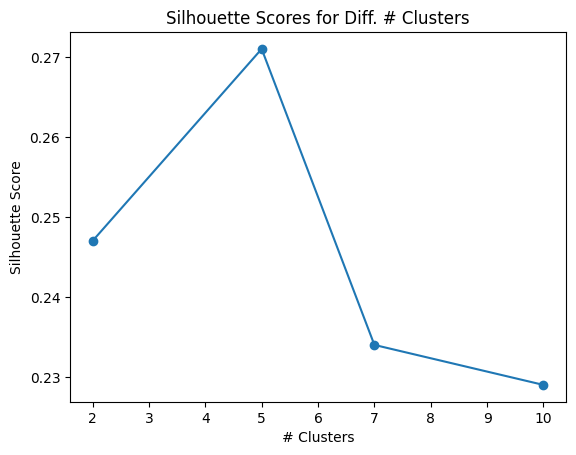

In [10]:
print(np.unique(cluster_labels))
# 10 clusters: 0.229
# 7 clusters: 0.234
# 5 clusters: 0.271
# 2 clusters: 0.247
n_clusters = [2, 5, 7, 10]
scores = [0.247, 0.271, 0.234, 0.229]
plt.plot(n_clusters, scores, marker='o')
plt.title("Silhouette Scores for Diff. # Clusters")
plt.xlabel("# Clusters")
plt.ylabel("Silhouette Score")

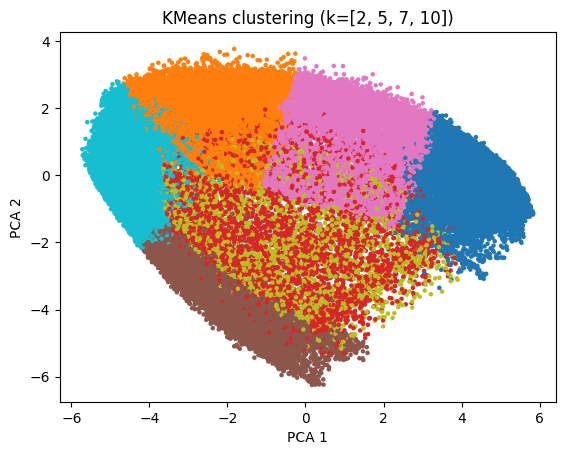

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_pca = PCA(n_components=2).fit_transform(X_subset)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=5)
plt.title(f"KMeans clustering (k={n_clusters})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()